In [1]:
import argparse, json, time, random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from whobpyt.data_loader import DEVICE
from simulators.rww_simulator import RWWSubjectSimulator
from whobpyt.custom_cost_RWW import CostsRWW
from whobpyt.models.fc_cnn_disc import FCCNNDisc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import copy, itertools


Using DEVICE = cuda


In [2]:
def make_ring_sc(n=5, noise_std=0.05):
    """ Return ring SC with optional gaussian weight noise """
    sc = np.eye(n, k=1) + np.eye(n, k=-1)
    sc[0, -1] = sc[-1, 0] = 1
    if noise_std > 0:
        sc = sc + np.random.normal(scale=noise_std, size=sc.shape)
        # sc[sc < 0] = 0
    return sc / sc.sum(axis=1, keepdims=True)

def simulate_fc(sim, chunk_len, n_chunks, base=10):
    """ Run a simulator long enough, cut into chunks, return (B, n, n) """
    usable_ts = n_chunks * chunk_len
    ts, _ = sim.simulate(u=0, num_windows=usable_ts // chunk_len, base_window_num=base)    
    idxs = np.arange(0, ts.shape[1] - chunk_len + 1, chunk_len)
    fcs = [np.corrcoef(ts[:, i:i+chunk_len]) for i in idxs[:n_chunks]]
    return np.stack(fcs, axis=0)                    # (B, n, n)


In [3]:
class FCDataset(Dataset):
    """ Holds FC matrices (real=1 or fake=0) """
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):  return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [4]:
def build_gt_generator(node_size=5, g=80, g_EE=3.5, g_EI=0.42, step=0.05, tp=50, load=True, path="/vol/bitbucket/ank121/whobpyt/exp2_outputs/"):
    if load:
        sc = torch.tensor(np.load(path + "ring_sc.npy"), dtype=torch.float32, device=DEVICE)
    else:
        ring = torch.zeros(node_size, node_size)
        for i in range(node_size):
            ring[i, (i+1) % node_size] = np.random.rand()
        sc = ring / torch.norm(ring, p='fro')
        np.save(path + "ring_sc.npy", sc)
        sc = torch.tensor(sc, dtype=torch.float32, device=DEVICE)
    sim = RWWSubjectSimulator(sc, node_size=node_size, TP_per_window=tp,
                              fit_g_EE=False, fit_g_EI=False, use_fic=False,
                              g_EE_init=g_EE, g_EI_init=g_EI,
                              g_init=g, step_size=step)
    sim.model.to(DEVICE)
    return sim


def build_fake_generator(sc_np, g_range, gEE_range, gEI_range, tp=50, step=0.05):
    g     = random.uniform(*g_range)
    g_EE  = random.uniform(*gEE_range)
    g_EI  = random.uniform(*gEI_range)
    print(f"g={g} g_EE={g_EE} g_EI={g_EI}")
    sim   = RWWSubjectSimulator(torch.tensor(sc_np, dtype=torch.float32, device=DEVICE),
                                node_size=sc_np.shape[0], TP_per_window=tp,
                                fit_g_EE=False, fit_g_EI=False, use_fic=False,
                                g_EE_init=g_EE, g_EI_init=g_EI,
                                g_init=g, step_size=step)
    sim.model.to(DEVICE)
    return sim

In [5]:
chunk = 100
real_samples = 200
n_fake_subj = 20
fake_samples_per_subj = 40
batch = 16
epochs = 100
lr = 1e-4
step = 0.05
sc_noise = 0.05

g_range = [10, 150]
gEE_range = [1.0, 5.5]
gEI_range = [0.3, 0.6]

load_fake_fcs = True
load_real_fcs = True
load_sc = True
load_disc = True

out_dir = "/vol/bitbucket/ank121/whobpyt/exp2_outputs"
disc_path = out_dir + "/disc_toy.pt"

In [11]:
out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)
writer  = SummaryWriter(log_dir=out_dir / "tb")

gt_sim = build_gt_generator(step=step, tp=chunk, load=load_sc)
if load_real_fcs:
    real_fcs = np.load(out_dir / "real_fc.npy")
else:
    real_fcs = simulate_fc(gt_sim, chunk_len=chunk, n_chunks=real_samples)
    np.save(out_dir/"real_fc.npy", real_fcs)

if load_fake_fcs:
    fake_fcs = np.load(out_dir / "fake_fc.npy")
else:
    fake_fcs = []
    for _ in range(n_fake_subj):
        sc_np = make_ring_sc(noise_std=sc_noise)
        fake_sim = build_fake_generator(sc_np,
                                        g_range=g_range,
                                        gEE_range=gEE_range,
                                        gEI_range=gEI_range,
                                        tp=chunk, step=step)
        fake_mats = simulate_fc(fake_sim, chunk_len=chunk, n_chunks=fake_samples_per_subj)
        fake_fcs.append(fake_mats)
    fake_fcs = np.concatenate(fake_fcs, axis=0)
    np.save(out_dir/"fake_fc.npy", fake_fcs)


print(real_fcs.shape)
print(fake_fcs.shape)

X = np.concatenate([real_fcs, fake_fcs])
y = np.concatenate([np.ones(len(real_fcs)), np.zeros(len(fake_fcs))])      

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

print({k:v.shape[0] for k,v in
      dict(train=X_train, val=X_val, test=X_test).items()})



(200, 5, 5)
(800, 5, 5)
{'train': 800, 'val': 100, 'test': 100}


In [19]:
def make_loader(x, y, batch, shuffle):
    ds = FCDataset(x, y)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

train_dl = make_loader(X_train, y_train, batch=batch, shuffle=True)
val_dl   = make_loader(X_val,   y_val,   batch=256,  shuffle=False)
test_dl  = make_loader(X_test,  y_test,  batch=256,  shuffle=False)

disc = FCCNNDisc(n_nodes=gt_sim.model.node_size).to(DEVICE)
if load_disc:
    disc.load_state_dict(torch.load(disc_path, map_location=DEVICE))
optD = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
bce  = torch.nn.BCELoss()

In [20]:
best_auc, best_state = 0.0, None

for epoch in range(1, epochs+1):
    # train 
    disc.train()
    total_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optD.zero_grad()
        loss = bce(disc(xb), yb)
        total_loss += loss.item()
        loss.backward()
        optD.step()
    print(f"mean loss = {total_loss / len(train_dl):.4f}")
    # validation 
    disc.eval(); preds, targets = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            preds.append(disc(xb.to(DEVICE)).cpu())
            targets.append(yb)
    preds   = torch.cat(preds).squeeze().numpy()
    targets = torch.cat(targets).squeeze().numpy()
    val_auc = roc_auc_score(targets, preds)

    print(f"epoch {epoch:3d}/{epochs}   val-AUROC = {val_auc:.4f}")
    writer.add_scalar("val/auroc", val_auc, epoch)



mean loss = 0.6517
epoch   1/100   val-AUROC = 0.9050
mean loss = 0.4955
epoch   2/100   val-AUROC = 0.9475
mean loss = 0.3580
epoch   3/100   val-AUROC = 0.9856
mean loss = 0.2396
epoch   4/100   val-AUROC = 0.9938
mean loss = 0.1621
epoch   5/100   val-AUROC = 0.9963
mean loss = 0.1176
epoch   6/100   val-AUROC = 0.9969
mean loss = 0.0892
epoch   7/100   val-AUROC = 0.9981
mean loss = 0.0805
epoch   8/100   val-AUROC = 0.9988
mean loss = 0.0628
epoch   9/100   val-AUROC = 0.9988
mean loss = 0.0568
epoch  10/100   val-AUROC = 0.9981
mean loss = 0.0409
epoch  11/100   val-AUROC = 0.9988
mean loss = 0.0425
epoch  12/100   val-AUROC = 1.0000
mean loss = 0.0394
epoch  13/100   val-AUROC = 1.0000
mean loss = 0.0338
epoch  14/100   val-AUROC = 1.0000
mean loss = 0.0299
epoch  15/100   val-AUROC = 1.0000
mean loss = 0.0321
epoch  16/100   val-AUROC = 1.0000
mean loss = 0.0289
epoch  17/100   val-AUROC = 1.0000
mean loss = 0.0198
epoch  18/100   val-AUROC = 0.9994
mean loss = 0.0284
epoch  19

In [21]:
disc.eval(); preds, targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        preds.append(disc(xb.to(DEVICE)).cpu())
        targets.append(yb)
preds   = torch.cat(preds).squeeze().numpy()
targets = torch.cat(targets).squeeze().numpy()

test_auc  = roc_auc_score(targets, preds)
test_acc  = accuracy_score(targets, preds>0.5)
cm        = confusion_matrix(targets, preds>0.5)

print(f"TEST  AUROC = {test_auc:.3f}   ACC = {test_acc:.3f}")
print("Confusion matrix\n", cm)

# save model
torch.save(disc.state_dict(), disc_path)


TEST  AUROC = 1.000   ACC = 1.000
Confusion matrix
 [[80  0]
 [ 0 20]]


/tmp/ipykernel_2888213/22284499.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i].set_title(f"Label: {int(label)}\nDisc: {disc_out:.3f}")


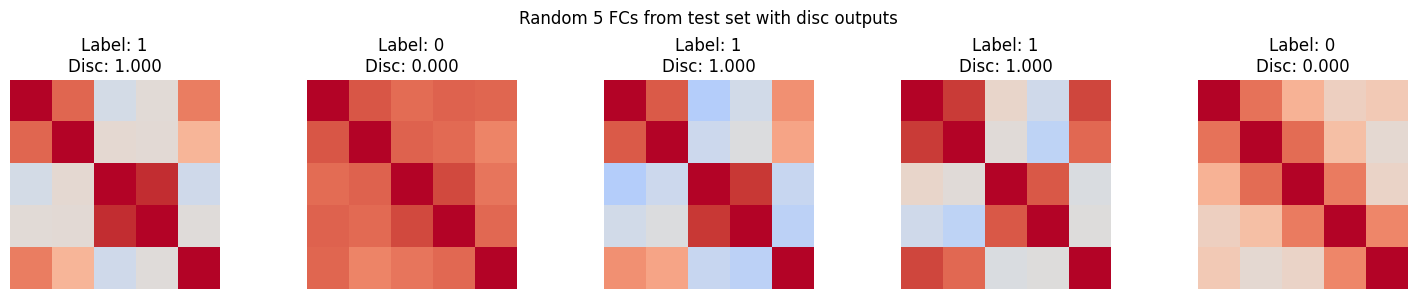

In [ ]:
# Select 5 random samples from the test data loader and plot their FCs with discriminator outputs
def visualise_disc_pred_test_dl(disc, test_dl):
    n = 5
    fc_list = []
    label_list = []
    for xb, yb in test_dl:
        fc_list.append(xb.cpu().numpy())
        label_list.append(yb.cpu().numpy())
    fc_arr = np.concatenate(fc_list, axis=0)  # shape: (num_samples, 1, N, N) or (num_samples, N, N)
    label_arr = np.concatenate(label_list, axis=0)  # shape: (num_samples,)

    # Remove channel dim if present
    if fc_arr.ndim == 4:
        fc_arr = fc_arr[:,0]

    num_samples = fc_arr.shape[0]
    random_indices = np.random.choice(num_samples, n, replace=False)

    fig, axs = plt.subplots(1, n, figsize=(3*n, 3))
    for i, idx in enumerate(random_indices):
        fc = fc_arr[idx]
        label = label_arr[idx]
        fc_tensor = torch.from_numpy(fc).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
        disc_out = float(disc(fc_tensor).item())
        axs[i].imshow(fc, vmin=-1, vmax=1, cmap="coolwarm")
        axs[i].set_title(f"Label: {int(label)}\nDisc: {disc_out:.3f}")
        axs[i].axis("off")
    plt.suptitle(f"Random {n} FCs from test set with disc outputs")
    plt.tight_layout()
    plt.show()

# def visualise_disc_pred(disc, real_fc, fake_fc, subj=18):
#     n = 5
#     fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
#     fake_outputs = []
#     for i in range(n):
#         random_index = np.random.choice(range(len(real_fc)))
#         # Fake FC
#         fake_fc_i = fake_fc[random_index]
#         print(f"fake_fc_i: {fake_fc_i.shape}")
#         # Prepare for discriminator: (1, 1, N, N) torch tensor
#         fake_fc_tensor = torch.from_numpy(fake_fc_i).float().unsqueeze(0).unsqueeze(0).to(disc.device if hasattr(disc, "device") else next(disc.parameters()).device)
#         print(f"fake_fc_tensor: {fake_fc_tensor.shape}")
#         p_fake = float(disc(fake_fc_tensor).item())
#         fake_outputs.append(p_fake)
#         axs[0, i].imshow(fake_fc_i, vmin=-1, vmax=1, cmap="coolwarm")
#         axs[0, i].set_title(f"Fake\nDisc: {p_fake:.3f}")
#         axs[0, i].axis("off")
#         # Real FC
#         real_fc_i = real_fc[random_index]  # numpy array, shape (N, N)
#         real_fc_tensor = torch.from_numpy(real_fc_i).float().unsqueeze(0).unsqueeze(0).to(disc.device if hasattr(disc, "device") else next(disc.parameters()).device)
#         p_real = float(disc(real_fc_tensor).item())
#         axs[1, i].imshow(real_fc_i, vmin=-1, vmax=1, cmap="coolwarm")
#         axs[1, i].set_title(f"Real\nDisc: {p_real:.3f}")
#         axs[1, i].axis("off")
#     plt.suptitle(f"Disc outputs for {n} fake FCs (top) and {n} real FCs (bottom) | Subject {subj}")
#     plt.tight_layout()
#     plt.show()

# visualise_disc_pred(disc, real_fcs, fake_fcs, subj=0)

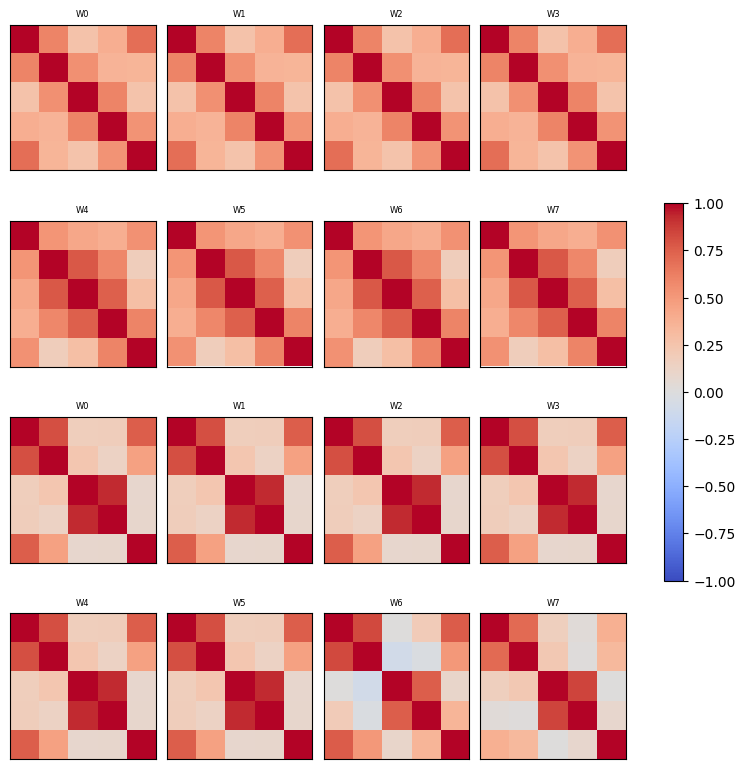

In [118]:
# Plot debugging
vmax=1
random.shuffle(fake_fcs); random.shuffle(real_fcs)
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, (ax, fc) in enumerate(zip(axs.flat[:8], fake_fcs)):
    im = ax.imshow(fc, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"W{i}", fontsize=6)
for i, (ax, fc) in enumerate(zip(axs.flat[8:], real_fcs)):
    im = ax.imshow(fc, vmin=-vmax, vmax=vmax, cmap="coolwarm")
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"W{i}", fontsize=6)

plt.tight_layout()
plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5)
fig.show()

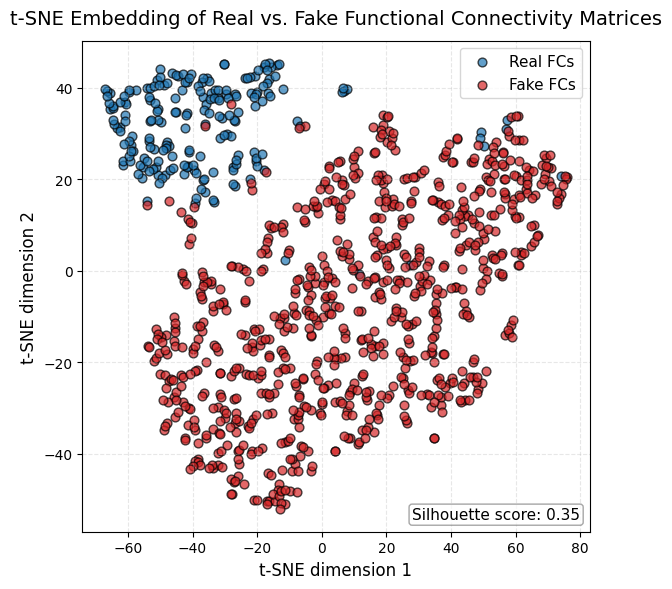

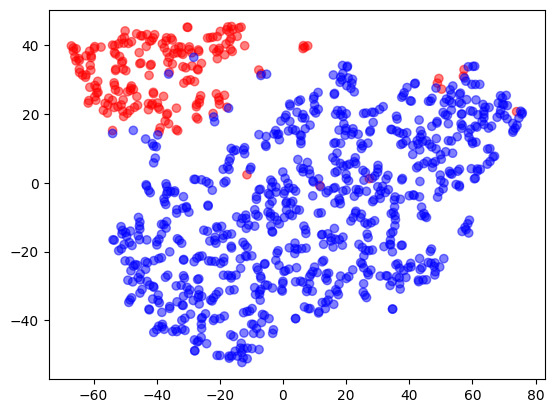

In [18]:
from sklearn.manifold import TSNE
z = np.vstack([real_fcs.reshape(len(real_fcs), -1),
               fake_fcs.reshape(len(fake_fcs), -1)])
y = np.array([1]*len(real_fcs)+[0]*len(fake_fcs))
# Run t-SNE for 2D embedding of real vs. fake FCs
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
z2d = tsne.fit_transform(z)

# Plot with improved scientific quality
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(
    z2d[y==1, 0], z2d[y==1, 1], 
    c='tab:blue', label='Real FCs', alpha=0.7, s=40, edgecolor='k'
)
scatter2 = ax.scatter(
    z2d[y==0, 0], z2d[y==0, 1], 
    c='tab:red', label='Fake FCs', alpha=0.7, s=40, edgecolor='k'
)
ax.set_xlabel("t-SNE dimension 1", fontsize=12)
ax.set_ylabel("t-SNE dimension 2", fontsize=12)
ax.set_title("t-SNE Embedding of Real vs. Fake Functional Connectivity Matrices", fontsize=14, pad=12)
ax.legend(fontsize=11, loc='best', frameon=True)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Quantitative separation: compute and display silhouette score
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(z2d, y)
ax.text(
    0.65, 0.05, f"Silhouette score: {sil_score:.2f}", 
    transform=ax.transAxes, fontsize=11, va='top', ha='left',
    bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="gray", alpha=0.7)
)

plt.show()
plt.scatter(z2d[:,0], z2d[:,1], c=y, cmap='bwr', alpha=.5)


### Discriminator Generalisation Experiment

In [25]:
import numpy as np, torch, random, copy, argparse
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

In [26]:
def get_fc_pool(chunk=100, real=200, fake_subj=20, fake_per=40,
                g_range=[10, 150], gEE=[1, 5.5], gEI=[0.3, 0.6],
                sc_noise=0.05):
    gt = build_gt_generator(tp=chunk)
    path = "/vol/bitbucket/ank121/whobpyt/exp2_outputs/"
    real_fcs = np.load(path + "real_fc.npy")
    fake_fcs = np.load(path + "fake_fc.npy")
    X = np.concatenate([real_fcs, fake_fcs])
    y = np.concatenate([np.ones(len(real_fcs)), np.zeros(len(fake_fcs))])
    X = (X - X.mean()) / X.std()
    return X, y

fold 0  AUROC=1.000  ACC=0.995
fold 1  AUROC=1.000  ACC=0.995
fold 2  AUROC=1.000  ACC=1.000
fold 3  AUROC=1.000  ACC=0.995
fold 4  AUROC=1.000  ACC=0.985

Mean±SD AUROC  net= 1.000±0.000 | LR= 1.000


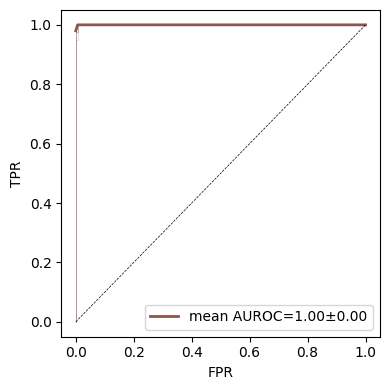

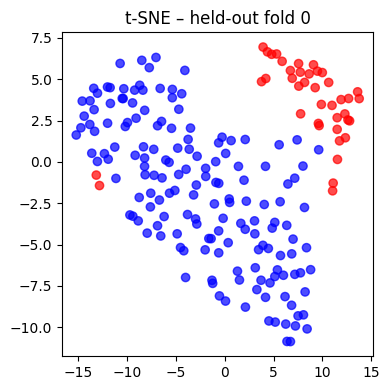

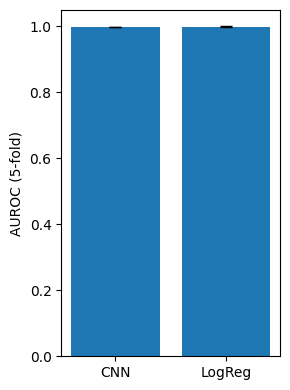

In [158]:
def run_cv():
    X, y = get_fc_pool()
    X_vec = X.reshape(len(X), -1)     # for logistic baseline

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_curves, aucs, accs, baselines = [], [], [], []

    for k, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        # ----- Dataloader -----
        train_ds = FCDataset(X[train_idx], y[train_idx])
        test_ds  = FCDataset(X[test_idx],  y[test_idx])
        train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
        test_dl  = torch.utils.data.DataLoader(test_ds,  batch_size=256, shuffle=False)

        # ----- model -----
        net = FCCNNDisc(n_nodes=5).to(DEVICE)
        opt = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.5,0.999))
        crit= torch.nn.BCELoss()

        # quick 50-epoch training
        for ep in range(50):
            net.train()
            for xb,yb in train_dl:
                xb,yb = xb.to(DEVICE), yb.to(DEVICE)
                opt.zero_grad()
                crit(net(xb), yb).backward()
                opt.step()

        # eval
        net.eval(); preds, tgt = [], []
        with torch.no_grad():
            for xb,yb in test_dl:
                preds.append(net(xb.to(DEVICE)).cpu())
                tgt.append(yb)
        preds = torch.cat(preds).squeeze().numpy()
        tgt   = torch.cat(tgt).squeeze().numpy()

        fpr, tpr, _ = roc_curve(tgt, preds)
        roc_curves.append((fpr,tpr))
        aucs.append(roc_auc_score(tgt, preds))
        accs.append(accuracy_score(tgt, preds>0.5))

        # logistic baseline on same fold
        lr_clf = LogisticRegression(max_iter=1000, class_weight="balanced")
        lr_clf.fit(X_vec[train_idx], y[train_idx])
        lr_preds = lr_clf.predict_proba(X_vec[test_idx])[:,1]
        baselines.append(roc_auc_score(tgt, lr_preds))

        print(f"fold {k}  AUROC={aucs[-1]:.3f}  ACC={accs[-1]:.3f}")

        # save t-SNE for first fold
        if k==0:
            tsne = TSNE(perplexity=30, init="pca", random_state=0)
            z = tsne.fit_transform(X_vec[test_idx])
            np.savez("tsne_fold0.npz", z=z, y=tgt)

    print(f"\nMean±SD AUROC  net= {np.mean(aucs):.3f}±{np.std(aucs):.3f} | "
          f"LR= {np.mean(baselines):.3f}")

    # ------ plots --------------------------------------------------
    # 1) ROC with ±1 SD
    all_fpr = np.unique(np.concatenate([rc[0] for rc in roc_curves]))
    mean_tpr = np.zeros_like(all_fpr)
    for fpr,tpr in roc_curves:
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(roc_curves)
    plt.figure(figsize=(4,4))
    for fpr,tpr in roc_curves:
        plt.plot(fpr,tpr,lw=.5,alpha=.3)
    plt.plot(all_fpr, mean_tpr, lw=2,
             label=f"mean AUROC={np.mean(aucs):.2f}±{np.std(aucs):.2f}")
    plt.plot([0,1],[0,1],'k--',lw=.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.tight_layout(); plt.show()
    # plt.savefig("roc_cv.png",dpi=150)

    # 2) t-SNE
    ts = np.load("tsne_fold0.npz")
    plt.figure(figsize=(4,4))
    plt.scatter(ts["z"][:,0], ts["z"][:,1], c=ts["y"], cmap="bwr", alpha=.7)
    plt.title("t-SNE - held-out fold 0"); plt.tight_layout()
    plt.show()
    # plt.savefig("tsne_fold0.png", dpi=150)

    # 3) AUROC bar-plot
    plt.figure(figsize=(3,4))
    plt.bar(["CNN","LogReg"], [np.mean(aucs), np.mean(baselines)],
            yerr=[np.std(aucs), np.std(baselines)], capsize=4)
    plt.ylabel("AUROC (5-fold)"); plt.tight_layout()
    plt.show()
    # plt.savefig("auroc_bar.png", dpi=150)


run_cv()

In [39]:
results_path = "/vol/bitbucket/ank121/whobpyt/exp2_outputs/"
weight_path = results_path + "disc_toy.pt"
stats_path = ""
sc_path = results_path + "ring_sc.npy"

g_true = 80
gEE_true = 3.5
gEI_true = 0.42
g_range = [30, 131, 5]

n_rep = 5
chunk = 100
step = 0.05

In [40]:
def load_disc(weight_path, n_nodes=5):
    disc = FCCNNDisc(n_nodes=n_nodes).to(DEVICE)
    disc.load_state_dict(torch.load(weight_path, map_location=DEVICE))
    disc.eval()
    return disc


def disc_score(disc, fc, mu=0, sigma=1):
    """ Return discriminator probability for a single FC """
    fc_z = torch.tensor((fc - mu) / sigma, dtype=torch.float32,
                        device=DEVICE).unsqueeze(0)
    with torch.no_grad():
        p = disc(fc_z).item()        # scalar prob(real)
    return p


In [52]:
def sweep_parameter(param_name, values, base_kwargs, disc,
                    gt_fc_vec, mu=0, sigma=1, n_rep=5, chunk=50):
    """
    For each value, simulate n_rep FCs, return mean + sd. disc score and FC-corr
    """
    scores, corrs = [], []
    for v in values:
        rep_scores, rep_corrs = [], []
        for it in range(n_rep):
            kwargs = base_kwargs.copy(); kwargs[param_name] = v
            sim = RWWSubjectSimulator(**kwargs)
            sim.model.to(DEVICE)
            fc = simulate_fc(sim, chunk, 1)[0]          # (5,5)
            score = disc_score(disc, fc, mu, sigma)
            # plt.imshow(fc, cmap='coolwarm')
            # plt.colorbar()
            # plt.title(f"{param_name}={kwargs[param_name]} FC. Disc score={score}")
            # plt.show()
            print(f"Disc score {it}: {score:.3f}")
            rep_scores.append(score)

            # static-FC corr to GT
            vec = fc[np.tril_indices(fc.shape[0], -1)]
            fc_corrs = [np.corrcoef(vec, fc)[0, 1] for fc in gt_fc_vec]
            print(fc_corrs)
            rep_corrs.append(np.mean(fc_corrs))

        scores.append((np.mean(rep_scores), np.std(rep_scores)))
        corrs.append((np.mean(rep_corrs),  np.std(rep_corrs)))
        print(f"{param_name}={v:6.2f}  score={scores[-1][0]:.3f}±{scores[-1][1]:.3f} "
              f"corr={corrs[-1][0]:.3f}")
    return np.asarray(scores), np.asarray(corrs)


[Simulator] Simulating 5 windows 


/tmp/ipykernel_2939837/1907557894.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


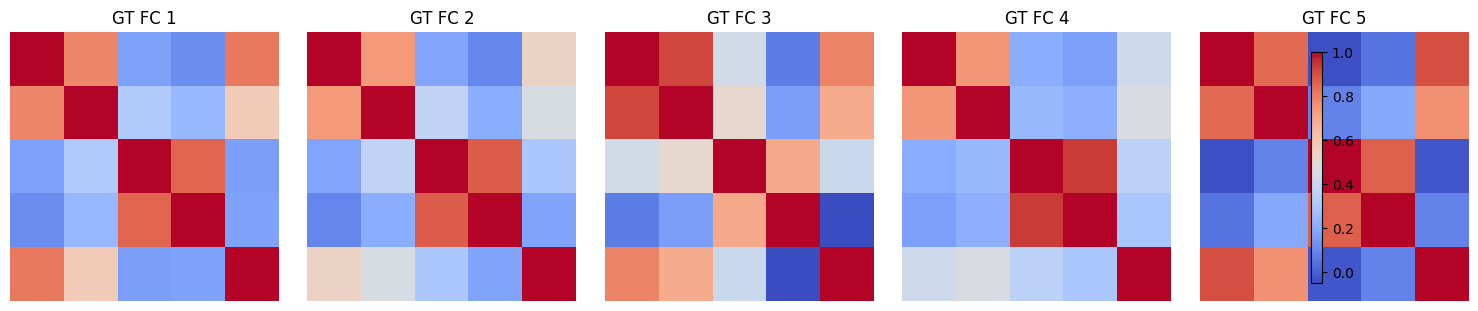

[Simulator] Simulating 1 windows 
Disc score 0: 1.000
[0.9029903690847026, 0.9273729092612368, 0.849878568927433, 0.8162870169565709, 0.8275340820712671]
[Simulator] Simulating 1 windows 
Disc score 1: 1.000
[0.9680398953868995, 0.9404551626812443, 0.7858839151464843, 0.9162281151186379, 0.958216666130489]
[Simulator] Simulating 1 windows 
Disc score 2: 0.993
[0.8762610886926786, 0.9547747155414752, 0.7191589151278738, 0.9097496989872271, 0.7682942230229264]
[Simulator] Simulating 1 windows 
Disc score 3: 1.000
[0.7596373695755879, 0.8562889806692535, 0.5819419630840051, 0.8744878036077867, 0.6649877901046012]
[Simulator] Simulating 1 windows 
Disc score 4: 1.000
[0.9810149537136235, 0.9355182531314159, 0.816377850536035, 0.8874985279665489, 0.97983217384272]
g_init= 30.00  score=0.999±0.003 corr=0.858
[Simulator] Simulating 1 windows 
Disc score 0: 1.000
[0.9793210867334524, 0.9566571629345643, 0.8685523893751308, 0.8864804871397629, 0.9502950652962207]
[Simulator] Simulating 1 window

NameError: name 'args' is not defined

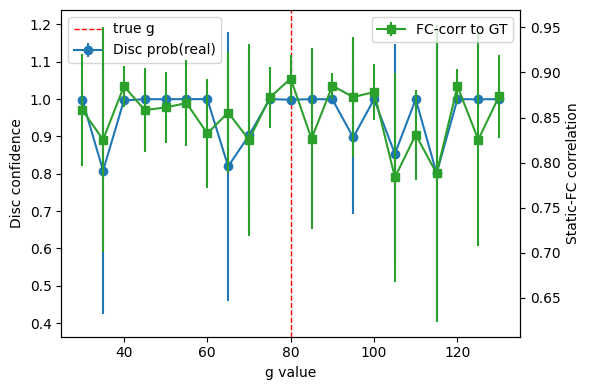

In [53]:
out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

gt_sim = build_gt_generator(tp=chunk)          # g=80, g_EE=3.5, g_EI=0.42
gt_fc = simulate_fc(gt_sim, chunk, 5)
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i, fc in enumerate(gt_fc):
    im = axs[i].imshow(fc, cmap='coolwarm', vmin=np.min(gt_fc), vmax=np.max(gt_fc))
    axs[i].set_title(f"GT FC {i+1}")
    axs[i].axis('off')
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()

# plt.imshow(gt_fc[0], cmap='coolwarm')
# plt.colorbar()
# plt.title("GT FC Matrix")
# plt.show()
gt_fc_vec = [fc[np.tril_indices(5, -1)] for fc in gt_fc]

disc = load_disc(weight_path, n_nodes=5)

if stats_path and Path(stats_path).exists():
    st = np.load(stats_path)
    mu, sigma = st["mu"], st["sigma"]
else:
    mu = 0; sigma = 1   #  no z-score → assume already centred

base_kwargs = dict(
    sc           = torch.tensor(np.load(sc_path), dtype=torch.float32, device=DEVICE),
    node_size    = 5,
    TP_per_window= chunk,
    fit_g_EE     = False,
    fit_g_EI     = False,
    use_fic      = False,
    step_size    = step,
    g_init       = g_true,
    g_EE_init    = gEE_true,
    g_EI_init    = gEI_true,
)


g_vals = np.arange(*g_range)      # e.g. 10 → 150 step 5
g_scores, g_corrs = sweep_parameter(
    "g_init", g_vals, base_kwargs, disc, gt_fc_vec,
    mu, sigma, n_rep=n_rep, chunk=chunk)

# 6) log & store
np.savez(out/"g_sweep.npz", g_vals=g_vals,
            scores=g_scores, corrs=g_corrs)

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.errorbar(g_vals, g_scores[:,0], yerr=g_scores[:,1],
                fmt="-o", label="Disc prob(real)")
ax1.set_xlabel("g value"); ax1.set_ylabel("Disc confidence")
ax1.axvline(g_true, ls="--", c="red", lw=1, label="true g")
ax2 = ax1.twinx()
ax2.errorbar(g_vals, g_corrs[:,0], yerr=g_corrs[:,1],
                fmt="s-", c="tab:green", label="FC-corr to GT")
ax2.set_ylabel("Static-FC correlation")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
fig.tight_layout(); #fig.savefig(out/"g_sweep_curves.png", dpi=150)
fig.show()

sel = [g_true, g_vals[0], g_vals[-1]]   # mid, low, high
fig, axs = plt.subplots(1, 3, figsize=(6,2))
for ax, g in zip(axs, sel):
    kwargs = base_kwargs.copy(); kwargs["g_init"]=g
    fc = simulate_fc(RWWSubjectSimulator(**kwargs).to(DEVICE),
                        chunk, 1)[0]
    sns.heatmap(fc, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, cbar=False)
    ax.set_title(f"g={g}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout(); #fig.savefig(out/"sample_FCs.png", dpi=150)
fig.show()

print(f"Outputs saved to {out.resolve()}")
# tb.close()


[Simulator] Simulating 1 windows 
[Simulator] Simulating 1 windows 
[Simulator] Simulating 1 windows 
Outputs saved to /vol/bitbucket/ank121/whobpyt/exp2_outputs


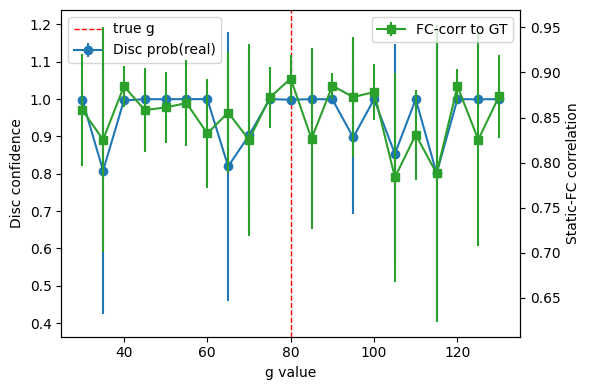

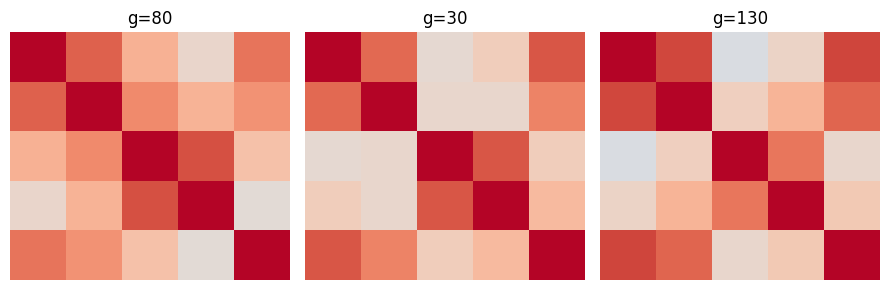

In [ ]:

fig, ax1 = plt.subplots(figsize=(6,4))
ax1.errorbar(g_vals, g_scores[:,0], yerr=g_scores[:,1],
                fmt="-o", label="Disc prob(real)")
ax1.set_xlabel("g value"); ax1.set_ylabel("Disc confidence")
ax1.axvline(g_true, ls="--", c="red", lw=1, label="true g")
ax2 = ax1.twinx()
ax2.errorbar(g_vals, g_corrs[:,0], yerr=g_corrs[:,1],
                fmt="s-", c="tab:green", label="FC-corr to GT")
ax2.set_ylabel("Static-FC correlation")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
fig.tight_layout(); fig.savefig(out/"g_sweep_curves.png", dpi=150)
# fig.show()

sel = [g_true, g_vals[0], g_vals[-1]]   # mid, low, high
fig, axs = plt.subplots(1, 3, figsize=(9, 3))  # Each subplot is square (3x3 inches)
for ax, g in zip(axs, sel):
    kwargs = base_kwargs.copy(); kwargs["g_init"]=g
    sim = RWWSubjectSimulator(**kwargs)
    sim.model.to(DEVICE)
    fc = simulate_fc(sim, chunk, 1)[0]
    sns.heatmap(fc, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, cbar=False)
    ax.set_title(f"g={g}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout(); fig.savefig(out/"sample_FCs.png", dpi=150)
# fig.show()

print(f"Outputs saved to {out.resolve()}")
# tb.close()
